Step 1: Load the MNIST dataset

In [234]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms

batch_size_train = 64
batch_size_test = 1000


n_epochs = 3

def loadDataSets():
    global mnist_trainset

    mnist_trainset = datasets.MNIST(root='./data', train=True,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

    global train_loader
    train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

    mnist_testset = datasets.MNIST(root='./data', train=False,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

    global test_loader
    test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=True)

loadDataSets()



Step 2: Plot a subset of the Dataset

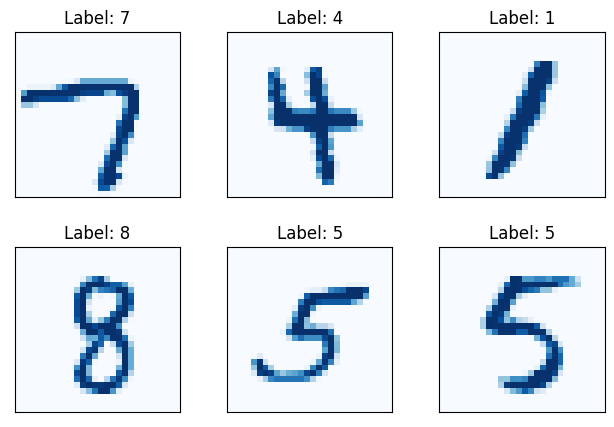

In [235]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='Blues', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


Step 3: Construct Model

In [236]:
import torch
from torch import nn

class CNN(torch.nn.Module):
    def __init__(self, initweights = False, usebias = False):
        super(CNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias = usebias)

        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias = usebias)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear_1 = nn.Linear(7 * 7 * 32, 128, bias=usebias)
        self.linear_2 = nn.Linear(128, 256, bias=usebias)
        self.linear_3 = nn.Linear(256, 10, bias=usebias)


        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        if initweights:
            nn.init.kaiming_normal_(self.conv_1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.conv_2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.linear_1.weight, mode='fan_in',nonlinearity='relu')
            nn.init.kaiming_normal_(self.linear_2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.xavier_normal_(self.linear_3.weight)


    def forward(self, x):
        x = self.conv_1(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)

        x = self.linear_2(x)
        x = self.sigmoid(x)
        x = self.linear_3(x)

        out = self.softmax(x)

        return out, x


def initializeModel(learning_rate, initweight = False, initbias = False):
    global cnn
    cnn = CNN(initweight, initbias)

    print(cnn)

    global loss_fn
    loss_fn = nn.CrossEntropyLoss()

    global optimizer
    optimizer = torch.optim.Adam(params=cnn.parameters(), lr=learning_rate)



Step 4: Training the Model

In [237]:
log_interval = 10
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    cnn.to(device)

    cnn.train()
    total_train_loss = 0

    for epoch in range(num_epochs):

        for itr, (image, label) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = cnn(image)[0]
            loss = loss_fn(pred, label)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            if itr % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, itr * len(image), len(train_loader.dataset), 100. * itr / len(train_loader), loss.item()))
                train_losses.append(loss.item())
                train_counter.append((itr*64) + ((epoch-1)*len(train_loader.dataset)))
                torch.save(cnn.state_dict(), './data/model.pth')
                torch.save(optimizer.state_dict(), './data/optimizer.pth')


Step 5: Test Model

In [238]:
def test():
  cnn.eval()
  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data, target in test_loader:
      networkoutput = cnn(data)[0]

      loss= loss_fn(networkoutput,target)
      running_loss+=loss.item()

      _, predicted = networkoutput.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()

  test_loss=running_loss/len(test_loader)
  accu=100.*correct/total

  test_losses.append(test_loss)

  print('Testing Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))


initializeModel(0.001, False, False)

train_losses = []
train_counter = []
test_losses = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


CNN(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1568, out_features=128, bias=False)
  (linear_2): Linear(in_features=128, out_features=256, bias=False)
  (linear_3): Linear(in_features=256, out_features=10, bias=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
Testing Loss: 2.303 | Accuracy: 10.320
The model will be running on cpu device
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302149
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.304482
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.294428
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.315732
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.306609
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.301691
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.297697
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.317512
Train Epo

Step 6: Show Model Performance

Text(0, 0.5, 'loss')

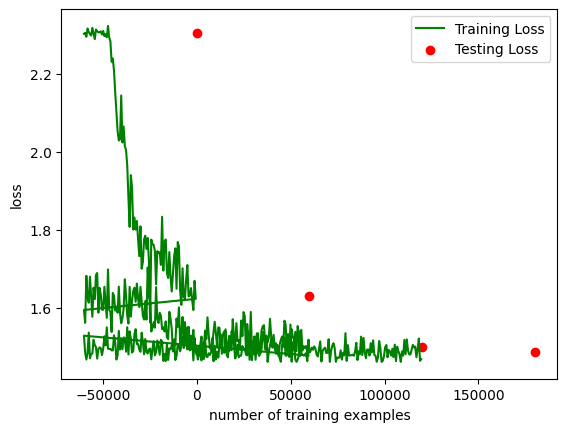

In [239]:

plt.plot(train_counter, train_losses, color='green')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.xlabel('number of training examples')
plt.ylabel('loss')




Step 8: Show prediction

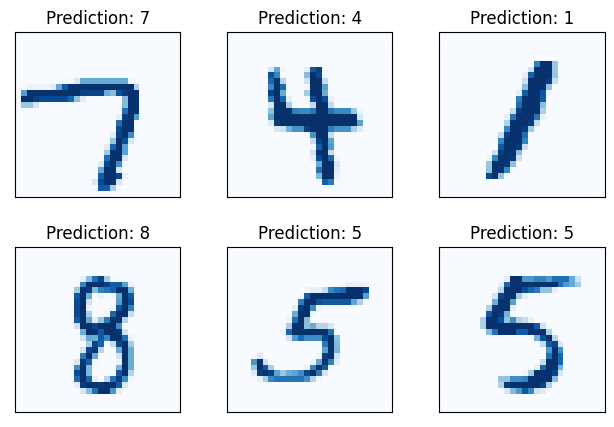

In [240]:
with torch.no_grad():
  output = cnn(example_data)[0]

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='Blues', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])